Using device: cuda
Model will be saved to: finalmodels/FFNN/Grid_10m/batch_size_3000/initial_lr_0.0005/epochs2000_p500_hs4196_blocks5/
Model architecture: 4196 hidden units, 5 residual blocks
epoch:1/2000 average TL:0.04575868 average VL:0.07182364 epoch time:2 seconds, lr:2.00e-05
epoch:11/2000 average TL:0.00337963 average VL:0.00297932 epoch time:1 seconds, lr:2.36e-05
epoch:21/2000 average TL:0.00199959 average VL:0.00166223 epoch time:1 seconds, lr:3.30e-05
epoch:31/2000 average TL:0.00155080 average VL:0.00263904 epoch time:1 seconds, lr:4.79e-05
epoch:41/2000 average TL:0.00097897 average VL:0.00114642 epoch time:1 seconds, lr:6.81e-05
epoch:51/2000 average TL:0.00103068 average VL:0.00183666 epoch time:1 seconds, lr:9.31e-05
epoch:61/2000 average TL:0.00097835 average VL:0.00090489 epoch time:1 seconds, lr:1.22e-04
epoch:71/2000 average TL:0.00091946 average VL:0.00495029 epoch time:1 seconds, lr:1.55e-04
epoch:81/2000 average TL:0.00057665 average VL:0.00034747 epoch time:1 se

epoch:871/2000 average TL:0.00004016 average VL:0.00001623 epoch time:1 seconds, lr:3.47e-04
epoch:881/2000 average TL:0.00004709 average VL:0.00002525 epoch time:1 seconds, lr:3.43e-04
epoch:891/2000 average TL:0.00004245 average VL:0.00002163 epoch time:1 seconds, lr:3.39e-04
epoch:901/2000 average TL:0.00005106 average VL:0.00001133 epoch time:1 seconds, lr:3.35e-04
epoch:911/2000 average TL:0.00005408 average VL:0.00002119 epoch time:1 seconds, lr:3.31e-04
epoch:921/2000 average TL:0.00004801 average VL:0.00001383 epoch time:1 seconds, lr:3.27e-04
epoch:931/2000 average TL:0.00003494 average VL:0.00000855 epoch time:1 seconds, lr:3.23e-04
epoch:941/2000 average TL:0.00003787 average VL:0.00001332 epoch time:1 seconds, lr:3.18e-04
epoch:951/2000 average TL:0.00003070 average VL:0.00001461 epoch time:1 seconds, lr:3.14e-04
epoch:961/2000 average TL:0.00004090 average VL:0.00001229 epoch time:1 seconds, lr:3.10e-04
epoch:971/2000 average TL:0.00004465 average VL:0.00002396 epoch time:

epoch:1751/2000 average TL:0.00001148 average VL:0.00000110 epoch time:1 seconds, lr:2.33e-05
epoch:1761/2000 average TL:0.00001346 average VL:0.00000138 epoch time:1 seconds, lr:2.14e-05
epoch:1771/2000 average TL:0.00001107 average VL:0.00000107 epoch time:1 seconds, lr:1.97e-05
epoch:1781/2000 average TL:0.00001131 average VL:0.00000117 epoch time:1 seconds, lr:1.81e-05
epoch:1791/2000 average TL:0.00001110 average VL:0.00000113 epoch time:1 seconds, lr:1.65e-05
epoch:1801/2000 average TL:0.00001233 average VL:0.00000101 epoch time:1 seconds, lr:1.49e-05
epoch:1811/2000 average TL:0.00001223 average VL:0.00000085 epoch time:1 seconds, lr:1.35e-05
epoch:1821/2000 average TL:0.00001141 average VL:0.00000102 epoch time:1 seconds, lr:1.21e-05
epoch:1831/2000 average TL:0.00001229 average VL:0.00000085 epoch time:1 seconds, lr:1.08e-05
epoch:1841/2000 average TL:0.00001081 average VL:0.00000090 epoch time:1 seconds, lr:9.59e-06
epoch:1851/2000 average TL:0.00001189 average VL:0.00000089 

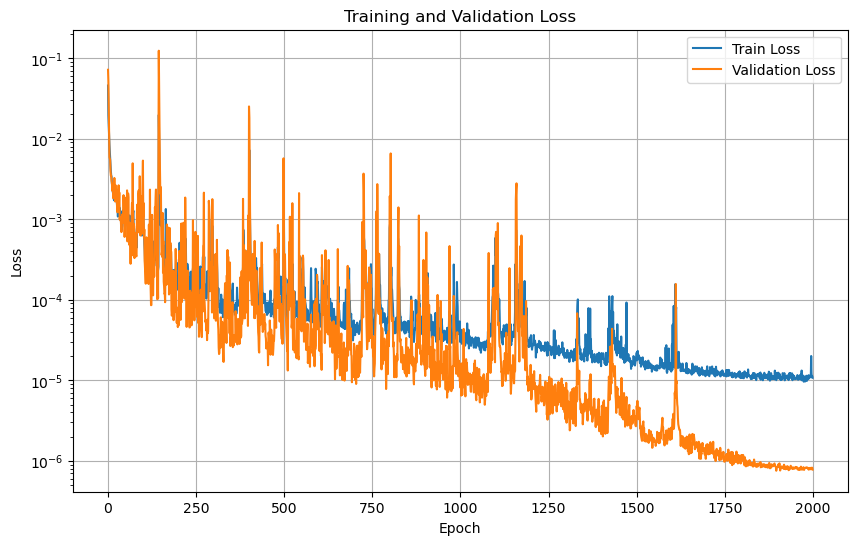

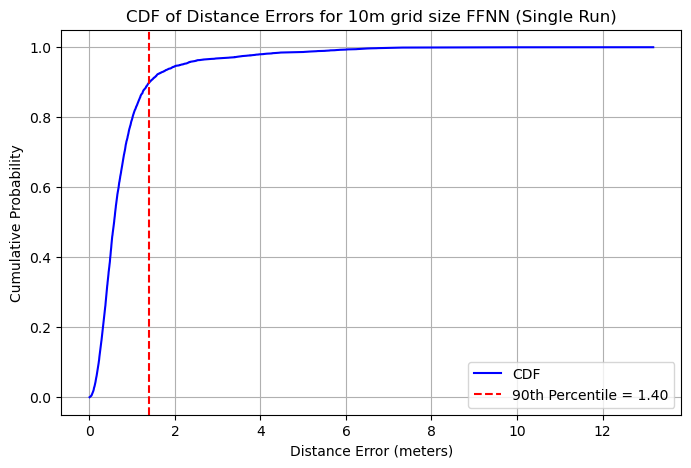

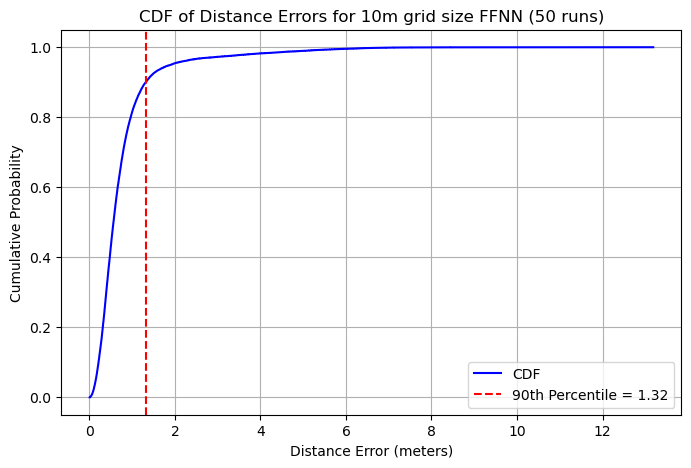

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Import libraries
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from typing import Dict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import time
from scipy.io import savemat
import dill as pickle
import thop
from scipy import stats

# GPU configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Select the GPU index

# Define all important parameters at the beginning
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 3000
lr = 5e-4
num_epochs = 2000
patience = 500
num_runs = 50  # Number of runs for statistical analysis
weight_decay = 1e-4
hidden_size = 4196
input_grid_size = 10  # Grid size in meters
train_size_ratio = 0.8
val_size_ratio = 0.20
# Learning rate scheduler with warm-up and cosine annealing
min_lr = 1e-6  # Define your desired minimum learning rate
num_residual_blocks = 5  # Increased from 2 to 5

folder_path = "Datasets/"
file_name = f"all_measurements_{input_grid_size}m_25k.json"
file_name_grid = f"all_measurements_grid_{input_grid_size}m.json"

# Create path directory for saving model weights and results
path_directory = f"finalmodels/FFNN/Grid_{input_grid_size}m/batch_size_{batch_size}/initial_lr_{lr}/epochs{num_epochs}_p{patience}_hs{hidden_size}_blocks{num_residual_blocks}/"

# Create directory if it doesn't exist
if not os.path.exists(path_directory):
    os.makedirs(path_directory)

def load_json_file(folder_path, file_name):
    file_path = Path(folder_path) / file_name
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found in '{folder_path}'")
        return None
    except json.JSONDecodeError:
        print(f"Error: Unable to parse JSON from file '{file_name}'")
        return None

def normalize_serving_cell_measurements(df):
    params = ['RSRP', 'RSRQ', 'RSSI', 'SINR']
    norm_params = {}
    
    for metric in params:
        col_name = f"Serving_{metric}"
        if col_name in df.columns:
            mean_val = df[col_name].mean()
            std_val = df[col_name].std()
            
            norm_params[f"{col_name}_mean"] = mean_val
            norm_params[f"{col_name}_std"] = std_val
            
            if std_val != 0:
                df[col_name] = (df[col_name] - mean_val) / std_val
            else:
                print(f"Warning: Standard deviation is 0 for {col_name}")
                df[col_name] = df[col_name] - mean_val
    
    return df, norm_params

def normalize_neighbor_cell_measurements(df, max_neighbors):
    params = ['RSRP', 'RSRQ', 'RSSI']
    norm_params = {}
    
    for i in range(1, max_neighbors + 1):
        for metric in params:
            col_name = f"Neighbor_{i}_{metric}"
            if col_name in df.columns:
                mean_val = df[col_name].mean()
                std_val = df[col_name].std()
                
                norm_params[f"{col_name}_mean"] = mean_val
                norm_params[f"{col_name}_std"] = std_val
                
                if std_val != 0:
                    df[col_name] = (df[col_name] - mean_val) / std_val
                else:
                    print(f"Warning: Standard deviation is 0 for {col_name}")
                    df[col_name] = df[col_name] - mean_val
    
    return df, norm_params

def normalize_position_minmax(df):
    x_min = df['X_Position'].min()
    x_max = df['X_Position'].max()
    y_min = df['Y_Position'].min()
    y_max = df['Y_Position'].max()
    
    position_params = {
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max
    }
    
    df['X_Position'] = (df['X_Position'] - x_min) / (x_max - x_min)
    df['Y_Position'] = (df['Y_Position'] - y_min) / (y_max - y_min)
    
    return df, position_params

def preprocess_data(json_data):
    ue_data = []
    max_neighbors = 0
    for ue_index, ue in enumerate(json_data['UEs']):
        ue_info = {
            'UE_ID': ue['id'],
            'X_Position': ue['position']['x'],
            'Y_Position': ue['position']['y'],
            'Serving_PCI': ue['servingCell']['pci'],
            'Serving_RSRP': ue['servingCell']['rsrp'],
            'Serving_RSRQ': ue['servingCell']['rsrq'],
            'Serving_RSSI': ue['servingCell']['rssi'],
            'Serving_SINR': ue['servingCell']['sinr'],
            'Closest_Grid_dist': ue['gridDetail']['gridCenterDistance'],
            'Closest_Grid_X': ue['gridDetail']['gridCenterX'],
            'Closest_Grid_Y': ue['gridDetail']['gridCenterY'],
            'Closest_Grid_ID': ue['gridDetail']['gridId']
        }
        
        if 'neighborCells' in ue and isinstance(ue['neighborCells'], list):
            for i, neighbor in enumerate(ue['neighborCells']):
                ue_info[f'Neighbor_{i+1}_RSRP'] = neighbor.get('rsrp', 0)
                ue_info[f'Neighbor_{i+1}_RSRQ'] = neighbor.get('rsrq', 0)
                ue_info[f'Neighbor_{i+1}_RSSI'] = neighbor.get('rssi', 0)
            max_neighbors = max(max_neighbors, len(ue['neighborCells']))
        
        ue_data.append(ue_info)
    
    df = pd.DataFrame(ue_data)
    
    for i in range(1, max_neighbors + 1):
        for metric in ['RSRP', 'RSRQ', 'RSSI']:
            col_name = f'Neighbor_{i}_{metric}'
            if col_name not in df.columns:
                df[col_name] = 0
            else:
                df[col_name] = df[col_name].fillna(0)
    
    df, position_params = normalize_position_minmax(df)
    df.attrs.update(position_params)
    
    df, serving_params = normalize_serving_cell_measurements(df)
    df.attrs.update(serving_params)
    
    df, neighbor_params = normalize_neighbor_cell_measurements(df, max_neighbors)
    df.attrs.update(neighbor_params)
    
    # Extracting the feature set
    features = np.array(df.drop(['UE_ID', 'X_Position', 'Y_Position', 'Serving_PCI', 'Closest_Grid_dist', 
                                'Closest_Grid_X', 'Closest_Grid_Y', 'Closest_Grid_ID'], axis=1))
    
    # Extracting labels
    labels = np.array(df[['X_Position', 'Y_Position']])
    
    # Ground truth grid details for the UEs
    grid_id = np.array(df['Closest_Grid_ID'])
    
    # Shuffle the data before splitting
    indices = np.arange(len(features))
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]
    grid_id = grid_id[indices]
    
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    grid_id = torch.tensor(grid_id, dtype=torch.float32)
    
    return features, labels, grid_id, df

class GridDataPreprocessor:
    def __init__(self, json_path, json_file: str):
        """
        Initialize the preprocessor with path to JSON file
        
        Args:
            json_path (str): Path to the JSON file containing grid data
        """
        self.json_path = Path(json_path)/json_file
        self.raw_data = self._load_json()
        
    def _load_json(self) -> Dict:
        """Load JSON file and return the data"""
        with open(self.json_path, 'r') as f:
            return json.load(f)
    
    def _extract_grid_coordinates(self, grid_dict: Dict) -> torch.Tensor:
        """
        Extract coordinates from a single grid dictionary
        
        Args:
            grid_dict (Dict): Dictionary containing grid information
            
        Returns:
            torch.Tensor: Tensor of shape (num_points, 3) containing [x, y, grid_id]
        """
        points = []
        for point in grid_dict['gridDictionary']:
            points.append([
                point['gridCenterX'],
                point['gridCenterY'],
                point['gridId']
            ])
        return torch.tensor(points, dtype=torch.float32)
    
    def process_data(self) -> Dict[str, torch.Tensor]:
        """
        Process all grids in the data
        
        Returns:
            Dict[str, torch.Tensor]: Dictionary containing:
                - 'coordinates': Tensor of shape (num_grids, num_points, 3)
                - 'grid_centers': Tensor of shape (num_grids, num_points, 2)
                - 'grid_ids': Tensor of shape (num_grids, num_points)
        """
        all_grids = []
        
        for grid in self.raw_data['GRIDs']:
            grid_tensor = self._extract_grid_coordinates(grid)
            all_grids.append(grid_tensor)
            
        # Stack all grids into a single tensor
        all_grids_tensor = torch.stack(all_grids)
        
        # Split into coordinates and grid IDs
        grid_centers = all_grids_tensor[..., :2]  # Shape: (num_grids, num_points, 2)
        grid_ids = all_grids_tensor[..., 2]      # Shape: (num_grids, num_points)
        
        return {
            'coordinates': all_grids_tensor,      # Full data
            'grid_centers': grid_centers,         # Just x,y coordinates
            'grid_ids': grid_ids                  # Just grid IDs
        }

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_rate=0.1):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_channels, in_channels),
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_channels, in_channels),
            nn.BatchNorm1d(in_channels)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

class ImprovedPositioningModel(nn.Module):
    def __init__(self, input_size, hidden_size=1024, output_size=2, num_residual_blocks=5):
        super(ImprovedPositioningModel, self).__init__()
        
        # Initial layer with larger width
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Increased number of residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_size) for _ in range(num_residual_blocks)
        ])
        
        # Enhanced decoder part with more layers and skip connections
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.BatchNorm1d(hidden_size//4),
            nn.ReLU(),
            nn.Linear(hidden_size//4, output_size),
            nn.Sigmoid()
        )
        
        # Place model on specified device
        self.to(device)
        
    def forward(self, x):
        x = self.input_layer(x)
        
        # Apply residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        x = self.decoder(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def train_model(model, train_loader, val_loader, num_epochs=1000, patience=500, learning_rate=1e-4, path_directory=None):
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Calculate required final_div_factor based on the desired min_lr
    final_div_factor = learning_rate / min_lr

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=25,  # Controls initial learning rate (max_lr/div_factor)
        final_div_factor=final_div_factor  # Controls final learning rate (max_lr/final_div_factor)
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_features, batch_labels in train_loader:
            # Move batch to device
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                # Move batch to device
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        epoch_time = time.time() - epoch_start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        if epoch % 10 == 0:
            print(f'epoch:{epoch+1}/{num_epochs} average TL:{avg_train_loss:.8f} average VL:{avg_val_loss:.8f} epoch time:{int(epoch_time)} seconds, lr:{current_lr:.2e}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Save model to the specified path directory
            if path_directory:
                model_path = path_directory + 'best_model.pth'
                torch.save(model.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    return train_losses, val_losses

def gaussian_grid_probability(predicted_coords, grid_centers, sigma=50):
    # Calculate distances
    distances = np.sqrt(((grid_centers - predicted_coords[:, np.newaxis]) ** 2).sum(axis=2))
    # Apply Gaussian kernel
    probabilities = np.exp(-distances**2 / (2 * sigma**2))
    return probabilities / probabilities.sum(axis=1, keepdims=True)

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, h

def softmax_grid_probability(predicted_coords, grid_centers, temperature=1.0):
    # Calculate distances
    distances = np.sqrt(((grid_centers - predicted_coords[:, np.newaxis]) ** 2).sum(axis=2))
    # Apply softmax with temperature scaling
    logits = -distances / temperature
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp_logits / exp_logits.sum(axis=1, keepdims=True)

if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Model will be saved to: {path_directory}")
    print(f"Model architecture: {hidden_size} hidden units, {num_residual_blocks} residual blocks")
    
    # Load data
    json_data = load_json_file(folder_path, file_name)
    if json_data is None:
        print("Error loading data")
        exit()
    
    # Process grid information
    preprocessor_grid = GridDataPreprocessor(folder_path, file_name_grid)
    processed_data_grid = preprocessor_grid.process_data()
    
    coordinates = processed_data_grid['coordinates'].to(device)
    grid_centers = processed_data_grid['grid_centers'].to(device)
    grid_ids = processed_data_grid['grid_ids'].to(device)
    center = grid_centers.cpu().numpy()[0]
    ids = grid_ids.cpu().numpy()[0]
    
    # Initial preprocessing for model training
    features, labels, grid_number, df = preprocess_data(json_data)
    
    # Get position normalization parameters for future use
    x_pos_min = df.attrs['x_min']
    x_pos_max = df.attrs['x_max']
    y_pos_min = df.attrs['y_min']
    y_pos_max = df.attrs['y_max']
    
    # Move tensors to device
    features = features.to(device)
    labels = labels.to(device)
    grid_number = grid_number.to(device)
    
    # Calculate split sizes
    total_samples = len(features)
    train_size = int(train_size_ratio * total_samples)
    
    # Split the data for training and validation/testing
    train_features = features[:train_size]
    train_labels = labels[:train_size]
    val_features = features[train_size:]
    val_labels = labels[train_size:]
    test_features = val_features  # Using validation set as test set
    test_labels = val_labels
    test_grid_ids = grid_number[train_size:]
    
    # Create datasets and dataloaders
    train_dataset = CustomDataset(train_features, train_labels)
    val_dataset = CustomDataset(val_features, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model with enhanced architecture
    input_size = features.shape[1]
    model = ImprovedPositioningModel(input_size, hidden_size, output_size=2, num_residual_blocks=num_residual_blocks)
    
    # Measure training time
    start_time = time.time()
    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        patience=patience,
        learning_rate=lr,
        path_directory=path_directory
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Calculate model FLOPs and parameters
    dummy_input = torch.randn(1, input_size).to(device)
    flops, params = thop.profile(model, inputs=(dummy_input,), verbose=False)
    print(f'Model FLOPs: {flops}')
    print(f'Model Params Num: {params}\n')
    
    # Save losses, flops, and parameters in dictionary
    losses_dict = {
        'train_losses': np.array(train_losses), 
        'val_losses': np.array(val_losses), 
        'flops': flops, 
        'parameters': params
    }
    
    # Save in both .mat and .pkl formats
    savemat(path_directory + 'losses.mat', losses_dict)
    with open(path_directory + 'losses.pkl', 'wb') as file:
        pickle.dump(losses_dict, file)
    
    # Save training curves as PDF
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(path_directory + 'training_curves.pdf')
    
    # Load the best model for evaluation
    model = ImprovedPositioningModel(input_size, hidden_size, num_residual_blocks=num_residual_blocks)
    model.load_state_dict(torch.load(path_directory + 'best_model.pth'))
    model.to(device)
    model.eval()
    
    # --- Initial single evaluation ---
    # Evaluate on test data
    with torch.no_grad():
        outputs_test = model(test_features)
    
    # Convert normalized predictions back to original scale
    predicted = outputs_test.detach().cpu().numpy()
    real = test_labels.cpu().numpy()
    
    # Denormalize predictions
    predicted[:,0] = x_pos_min + predicted[:,0]*(x_pos_max - x_pos_min)
    predicted[:,1] = y_pos_min + predicted[:,1]*(y_pos_max - y_pos_min)
    
    # Denormalize ground truth
    real[:,0] = x_pos_min + real[:,0]*(x_pos_max - x_pos_min)
    real[:,1] = y_pos_min + real[:,1]*(y_pos_max - y_pos_min)
    
    # Calculate distances for grid prediction
    distances = np.sqrt((center[:, np.newaxis, 0] - predicted[:, 0])**2 + 
                        (center[:, np.newaxis, 1] - predicted[:, 1])**2)
    
    # Calculate prediction accuracy using different methods
    # 1. Using reciprocal of distances
    reciprocals = 1 / distances
    column_sums = reciprocals.sum(axis=0)
    probabilities_rec = reciprocals / column_sums
    grid_predicted = np.argmax(probabilities_rec, axis=0)
    grid_real = test_grid_ids.cpu().numpy()
    accuracy = metrics.accuracy_score(grid_real, grid_predicted)
    
    # 2. Using Gaussian kernel
    probabilities_gauss = gaussian_grid_probability(predicted, center, sigma=50)
    grid_predicted_gauss = np.argmax(probabilities_gauss, axis=1)
    accuracy_gauss = metrics.accuracy_score(grid_real, grid_predicted_gauss)
    
    # 3. Using softmax
    probabilities_softmax = softmax_grid_probability(predicted, center, temperature=1.0)
    grid_predicted_softmax = np.argmax(probabilities_softmax, axis=1)
    accuracy_softmax = metrics.accuracy_score(grid_real, grid_predicted_softmax)
    
    # Calculate positioning error
    distance_error = np.linalg.norm(real - predicted, axis=1)
    mean_error = np.mean(distance_error)
    percentile_90 = np.percentile(distance_error, 90)
    
    # Save the confusion matrix for grid prediction
    conf_matrix = confusion_matrix(grid_real, grid_predicted, labels=ids)
    np.save(path_directory + 'confusion_matrix.npy', conf_matrix)
    
    # Print and save single run results
    print(f"\n--- Single Run Results ---")
    print(f"Grid Size: {input_grid_size}m")
    print(f"Mean 2D Error: {mean_error:.2f} meters")
    print(f"90th Percentile Error: {percentile_90:.2f} meters")
    print(f"Grid Accuracy (Reciprocal): {accuracy:.4f}")
    print(f"Grid Accuracy (Gaussian): {accuracy_gauss:.4f}")
    print(f"Grid Accuracy (Softmax): {accuracy_softmax:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    
    # Save results to file
    with open(path_directory + 'results_single.txt', 'w') as f:
        f.write(f"Grid Size: {input_grid_size}m\n")
        f.write(f"Number of Residual Blocks: {num_residual_blocks}\n")
        f.write(f"Mean 2D Error: {mean_error:.2f} meters\n")
        f.write(f"90th Percentile Error: {percentile_90:.2f} meters\n")
        f.write(f"Grid Accuracy (Reciprocal): {accuracy:.4f}\n")
        f.write(f"Grid Accuracy (Gaussian): {accuracy_gauss:.4f}\n")
        f.write(f"Grid Accuracy (Softmax): {accuracy_softmax:.4f}\n")
        f.write(f"Training Time: {training_time:.2f} seconds\n")
    
    # Plot CDF of positioning errors and save as PDF
    plt.figure(figsize=(8, 5))
    sorted_errors = np.sort(distance_error)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, cdf, label="CDF", color="blue")
    plt.axvline(percentile_90, color="red", linestyle="--", 
                label=f"90th Percentile = {percentile_90:.2f}")
    plt.xlabel("Distance Error (meters)")
    plt.ylabel("Cumulative Probability")
    plt.title(f"CDF of Distance Errors for {input_grid_size}m grid size FFNN (Single Run)")
    plt.legend()
    plt.grid()
    plt.savefig(path_directory + 'error_cdf_single.pdf')
    
    # Save performance metrics for single run
    metrics_dict_single = {
        'mean_error': mean_error,
        'percentile_90': percentile_90,
        'accuracy': accuracy,
        'accuracy_gauss': accuracy_gauss,
        'accuracy_softmax': accuracy_softmax,
        'training_time': training_time,
        'sorted_errors': sorted_errors,
        'cdf': cdf,
        'num_residual_blocks': num_residual_blocks
    }
    
    savemat(path_directory + 'metrics_single.mat', metrics_dict_single)
    with open(path_directory + 'metrics_single.pkl', 'wb') as file:
        pickle.dump(metrics_dict_single, file)
    
    # --- Multiple runs for statistical confidence ---
    print(f"\n--- Starting Multiple Run Analysis ({num_runs} runs) ---")
    
    # Lists to store metrics from all runs
    dist_prob_list = []  # Reciprocal distance accuracy
    gauss_prob_list = []  # Gaussian kernel accuracy
    softm_prob_list = []  # Softmax accuracy
    percentile_90_list = []  # 90th percentile errors
    mean_err_list = []  # Mean errors
    all_distance_errors = []  # All distance errors across all runs
    
    # Start multiple runs
    for run in range(num_runs):
        if run % 10 == 0:
            print(f"Run {run+1}/{num_runs}...")
            
        # Preprocess data with different random shuffling
        features_run, labels_run, grid_number_run, _ = preprocess_data(json_data)
        
        # Move tensors to device
        features_run = features_run.to(device)
        labels_run = labels_run.to(device)
        grid_number_run = grid_number_run.to(device)
        
        # Split the data for this run
        train_size = int(train_size_ratio * len(features_run))
        test_features_run = features_run[train_size:]
        test_labels_run = labels_run[train_size:]
        test_grid_ids_run = grid_number_run[train_size:]
        
        # Load the trained model
        model.load_state_dict(torch.load(path_directory + 'best_model.pth'))
        model.eval()
        
        # Evaluate on test data for this run
        with torch.no_grad():
            outputs_test_run = model(test_features_run)
        
        # Denormalize predictions
        predicted_run = outputs_test_run.detach().cpu().numpy()
        predicted_run[:,0] = x_pos_min + predicted_run[:,0]*(x_pos_max - x_pos_min)
        predicted_run[:,1] = y_pos_min + predicted_run[:,1]*(y_pos_max - y_pos_min)
        
        # Denormalize ground truth
        real_run = test_labels_run.cpu().numpy()
        real_run[:,0] = x_pos_min + real_run[:,0]*(x_pos_max - x_pos_min)
        real_run[:,1] = y_pos_min + real_run[:,1]*(y_pos_max - y_pos_min)
        
        # Calculate distances for grid prediction
        distances_run = np.sqrt((center[:, np.newaxis, 0] - predicted_run[:, 0])**2 + 
                            (center[:, np.newaxis, 1] - predicted_run[:, 1])**2)
        
        # Calculate reciprocal distance accuracy
        reciprocals_run = 1 / distances_run
        column_sums_run = reciprocals_run.sum(axis=0)
        probabilities_rec_run = reciprocals_run / column_sums_run
        grid_predicted_run = np.argmax(probabilities_rec_run, axis=0)
        grid_real_run = test_grid_ids_run.cpu().numpy()
        accuracy_run = metrics.accuracy_score(grid_real_run, grid_predicted_run)
        
        # Calculate Gaussian kernel accuracy
        probabilities_gauss_run = gaussian_grid_probability(predicted_run, center, sigma=50)
        grid_predicted_gauss_run = np.argmax(probabilities_gauss_run, axis=1)
        accuracy_gauss_run = metrics.accuracy_score(grid_real_run, grid_predicted_gauss_run)
        
        # Calculate softmax accuracy
        probabilities_softmax_run = softmax_grid_probability(predicted_run, center, temperature=1.0)
        grid_predicted_softmax_run = np.argmax(probabilities_softmax_run, axis=1)
        accuracy_softmax_run = metrics.accuracy_score(grid_real_run, grid_predicted_softmax_run)
        
        # Calculate positioning error
        distance_error_run = np.linalg.norm(real_run - predicted_run, axis=1)
        mean_error_run = np.mean(distance_error_run)
        percentile_90_run = np.percentile(distance_error_run, 90)
        
        # Store metrics for this run
        dist_prob_list.append(accuracy_run)
        gauss_prob_list.append(accuracy_gauss_run)
        softm_prob_list.append(accuracy_softmax_run)
        percentile_90_list.append(percentile_90_run)
        mean_err_list.append(mean_error_run)
        
        # Store all distance errors for comprehensive CDF
        all_distance_errors.extend(distance_error_run.tolist())
    
    # Calculate mean and confidence intervals for all metrics
    mean_accuracy, margin_of_error_accuracy = calculate_confidence_interval(dist_prob_list)
    mean_accuracy_gauss, margin_of_error_accuracy_gauss = calculate_confidence_interval(gauss_prob_list)
    mean_accuracy_softmax, margin_of_error_accuracy_softmax = calculate_confidence_interval(softm_prob_list)
    mean_percentile_90, margin_of_error_percentile_90 = calculate_confidence_interval(percentile_90_list)
    mean_2D_err, margin_of_error_2D_err = calculate_confidence_interval(mean_err_list)

    # Print results of multiple runs with confidence intervals
    print("\n--- Multiple Run Results with 95% Confidence Intervals ---")
    print(f"Mean 2D Error: {mean_2D_err:.2f} ± {margin_of_error_2D_err:.2f} meters")
    print(f"90th Percentile Error: {mean_percentile_90:.2f} ± {margin_of_error_percentile_90:.2f} meters")
    print(f"Grid Accuracy (Reciprocal): {mean_accuracy:.4f} ± {margin_of_error_accuracy:.4f}")
    print(f"Grid Accuracy (Gaussian): {mean_accuracy_gauss:.4f} ± {margin_of_error_accuracy_gauss:.4f}")
    print(f"Grid Accuracy (Softmax): {mean_accuracy_softmax:.4f} ± {margin_of_error_accuracy_softmax:.4f}")
    
    # Save results to file
    with open(path_directory + 'results_multiple.txt', 'w') as f:
        f.write(f"Grid Size: {input_grid_size}m\n")
        f.write(f"Number of Residual Blocks: {num_residual_blocks}\n")
        f.write(f"Number of runs: {num_runs}\n\n")
        f.write(f"Mean 2D Error: {mean_2D_err:.2f} ± {margin_of_error_2D_err:.2f} meters\n")
        f.write(f"90th Percentile Error: {mean_percentile_90:.2f} ± {margin_of_error_percentile_90:.2f} meters\n")
        f.write(f"Grid Accuracy (Reciprocal): {mean_accuracy:.4f} ± {margin_of_error_accuracy:.4f}\n")
        f.write(f"Grid Accuracy (Gaussian): {mean_accuracy_gauss:.4f} ± {margin_of_error_accuracy_gauss:.4f}\n")
        f.write(f"Grid Accuracy (Softmax): {mean_accuracy_softmax:.4f} ± {margin_of_error_accuracy_softmax:.4f}\n")
    
    # Plot comprehensive CDF from all runs
    plt.figure(figsize=(8, 5))
    all_sorted_errors = np.sort(all_distance_errors)
    all_cdf = np.arange(1, len(all_sorted_errors) + 1) / len(all_sorted_errors)
    
    # Calculate the 90th percentile from the combined errors
    all_percentile_90 = np.percentile(all_distance_errors, 90)
    
    plt.plot(all_sorted_errors, all_cdf, label="CDF", color="blue")
    plt.axvline(all_percentile_90, color="red", linestyle="--", 
                label=f"90th Percentile = {all_percentile_90:.2f}")
    plt.xlabel("Distance Error (meters)")
    plt.ylabel("Cumulative Probability")
    plt.title(f"CDF of Distance Errors for {input_grid_size}m grid size FFNN ({num_runs} runs)")
    plt.legend()
    plt.grid()
    plt.savefig(path_directory + 'error_cdf_multiple.pdf')
    
    # Save comprehensive metrics with confidence intervals
    metrics_dict_multiple = {
        'mean_error': mean_2D_err,
        'mean_error_margin': margin_of_error_2D_err,
        'percentile_90': mean_percentile_90,
        'percentile_90_margin': margin_of_error_percentile_90,
        'accuracy': mean_accuracy,
        'accuracy_margin': margin_of_error_accuracy,
        'accuracy_gauss': mean_accuracy_gauss,
        'accuracy_gauss_margin': margin_of_error_accuracy_gauss,
        'accuracy_softmax': mean_accuracy_softmax,
        'accuracy_softmax_margin': margin_of_error_accuracy_softmax,
        'num_runs': num_runs,
        'num_residual_blocks': num_residual_blocks,
        'all_sorted_errors': all_sorted_errors,
        'all_cdf': all_cdf,
        'all_percentile_90': all_percentile_90,
        'mean_errors_per_run': np.array(mean_err_list),
        'percentile_90_per_run': np.array(percentile_90_list),
        'accuracy_per_run': np.array(dist_prob_list),
        'accuracy_gauss_per_run': np.array(gauss_prob_list),
        'accuracy_softmax_per_run': np.array(softm_prob_list)
    }
    
    savemat(path_directory + 'metrics_multiple.mat', metrics_dict_multiple)
    with open(path_directory + 'metrics_multiple.pkl', 'wb') as file:
        pickle.dump(metrics_dict_multiple, file)
    
    print(f"\nAll results saved to {path_directory}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Total evaluation time for {num_runs} runs: {time.time() - start_time - training_time:.2f} seconds")